In [1]:
!pip install intel-tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires 

In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=6a5d608480158f11e70e9b9020ea7be473dfee34322dcf880a9eff88737ff0da
  Stored in directory: /root/.cache/pip/wheels/35/e4/69/cb99d996d14a2971b79b990d68b05a17d58ce530ff96090dfc
Successfully built imutils


In [3]:
import numpy as np 
import tensorflow as tf
import cv2
import os
import shutil
import itertools
import glob
import random
import imutils
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers

/opt/conda/lib/python3.7/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.7/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.7/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6Status12empty_stringB5cxx11Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.7/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.7/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.7/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data15DatasetOpKernel11TraceStringB5cxx11ERKNS_15OpKernelContextEb']

**Sampling images**

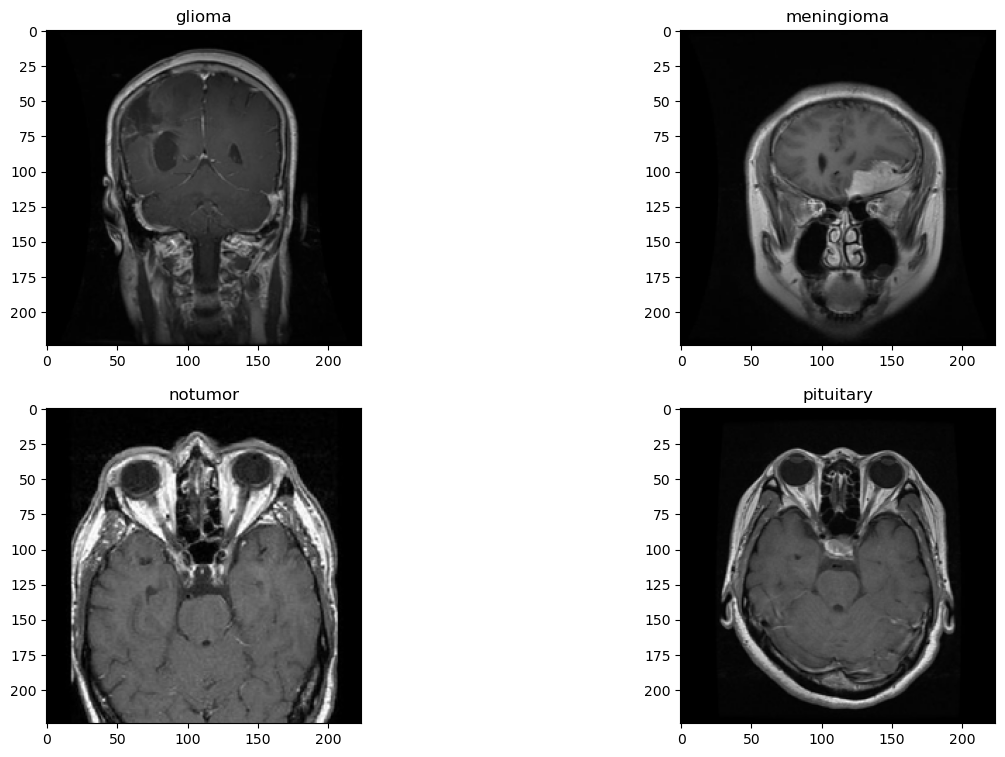

In [4]:
dirs=('/kaggle/input/brain-tumor-mri-dataset/Training')
categories=['glioma', 'meningioma', 'notumor', 'pituitary']
plt.figure(figsize=(15, 9))

img_path=['/glioma/Tr-gl_0010.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-piTr_0000.jpg']


for i in range(0, 4):
    ax=plt.subplot(2, 2, i + 1)
    img=cv2.imread(dirs + img_path[i])
    img=Image.fromarray(img, 'RGB')
    img=img.resize((224, 224))
    plt.imshow(img)
    plt.title(categories[i])

**Image Cropping** - To improve the overall composition by removing unwanted regions

In [5]:
def crop_img(img):
    # Find the extreme points and take a reactangle out of them
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # colored to grayscale image
    gray = cv2.GaussianBlur(gray, (3, 3), 0) # to reduce noise in the image
    
    # find contours in thresholded image, then grab the largest one
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations=2)
    thres = cv2.dilate(thres, None, iterations=2)
    # we usually want the focused part to be white for it to be detected correctly
    # Image contouring is process of identifying structural outlines of objects for better detection
    cntrs = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # image, contour retrieval method and contour approximation
    cntrs = imutils.grab_contours(cntrs) # actually obtain the contours
    c = max(cntrs, key=cv2.contourArea) # obtain the largest contour
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    
    # Now that we have obtained the largest contour of an image, we must determine the extreme points
    # find the extreme points

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # adding the contour on image
    img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

    # adding the extreme points
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    # crop
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img


In [6]:
training="/kaggle/input/brain-tumor-mri-dataset/Training"
testing="/kaggle/input/brain-tumor-mri-dataset/Testing"

training_dir=os.listdir(training)
testing_dir=os.listdir(testing)
img_size=256

for dir in training_dir:
    save_path='/kaggle/working/cropped/training/'+dir
    path=os.path.join(training, dir)
    image_dir=os.listdir(path)
    for img in image_dir:
        image=cv2.imread(os.path.join(path, img))
        new_img=crop_img(image)
        new_img=cv2.resize(new_img, (img_size, img_size))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)
        
for dir in testing_dir:
    save_path='/kaggle/working/cropped/testing/'+dir
    path=os.path.join(training, dir)
    image_dir=os.listdir(path)
    for img in image_dir:
        image=cv2.imread(os.path.join(path, img))
        new_img=crop_img(image)
        new_img=cv2.resize(new_img, (img_size, img_size))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)

**Demonstrating Contour Mapping**

In [7]:
img = cv2.imread('/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-meTr_0000.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

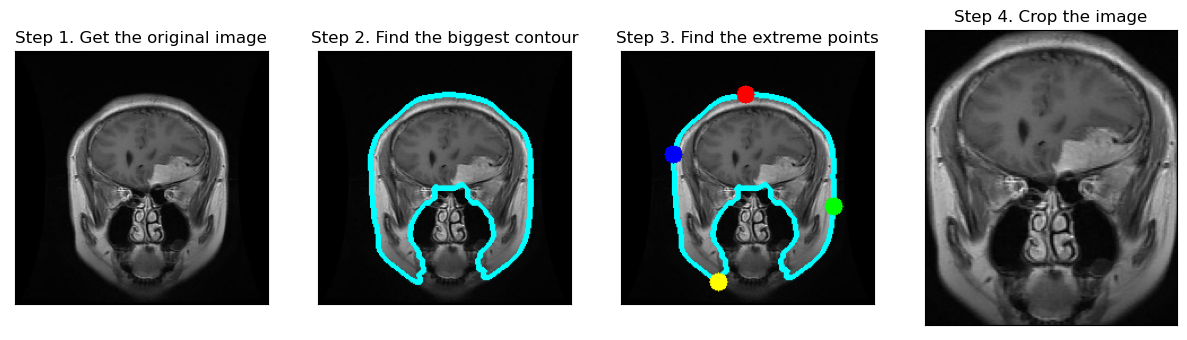

In [8]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

**Putting the images into train and test**

In [9]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/kaggle/working/cropped/training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/kaggle/working/cropped/testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

100%|██████████| 1457/1457 [00:01<00:00, 758.16it/s]


**Normalization of the image**

In [10]:
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

(5712, 200, 200, 3)
(5712, 200, 200, 3)


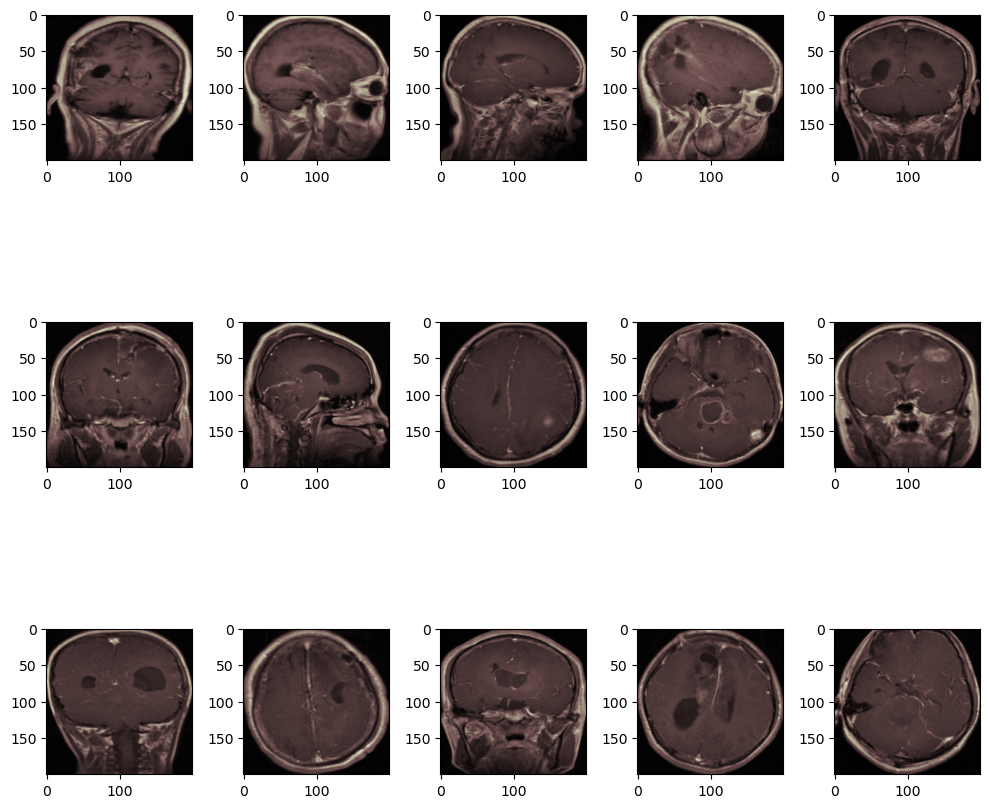

In [11]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()